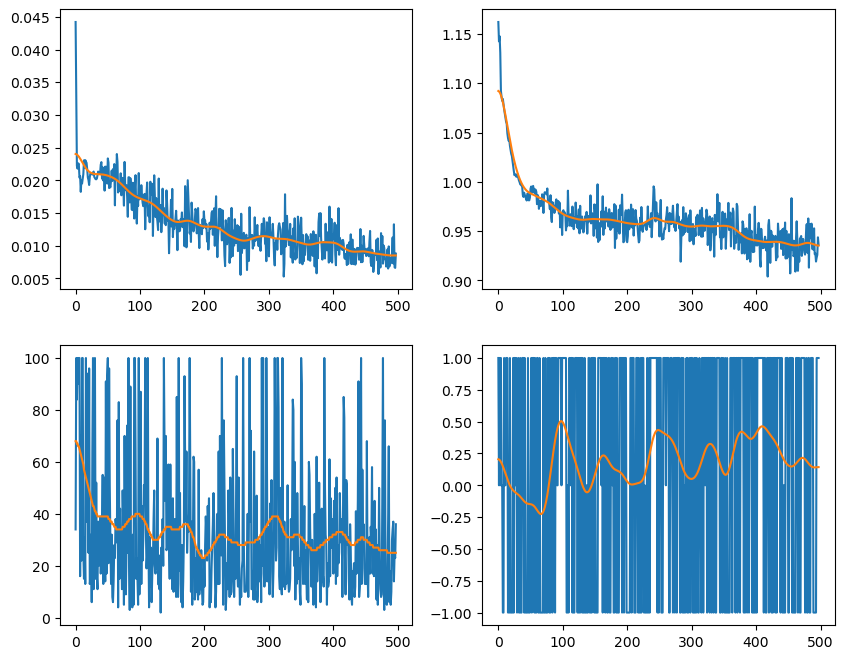

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
df = pd.read_csv('data/Omniscient/AC_loss.txt')
critic_loss = df['critic_loss'].to_numpy()
actor_loss = df['actor_loss'].to_numpy()
t = df['t'].to_numpy()
r = df['r'].to_numpy()
critic_loss_gau = gaussian_filter1d(critic_loss, sigma=10)
actor_loss_gau = gaussian_filter1d(actor_loss, sigma=10)
t_gau = gaussian_filter1d(t, sigma=10)
r_gau = gaussian_filter1d(r, sigma=10)
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.ravel()
ax[0].plot(critic_loss)
ax[0].plot(critic_loss_gau)
ax[1].plot(actor_loss)
ax[1].plot(actor_loss_gau)
ax[2].plot(t)
ax[2].plot(t_gau)
ax[3].plot(r)
ax[3].plot(r_gau)
fig.savefig('data/Omniscient/AWAC.png', dpi=300)

In [15]:
from hipposlam.utils import read_pickle
import numpy as np
data = read_pickle('data/Omniscient/naive_controller_data.pickle')

In [16]:
datacat = np.vstack(data['traj'])
datacat.shape


(15785, 15)

In [11]:
import numpy as np

foo = np.random.randint(1, 3, size=1)

foo.squeeze()


()

In [2]:
# Paths
from os.path import join
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from hipposlam.Networks import MLP
from hipposlam.Replay import Replayer, ReplayMemory, ReplayMemoryCat
from hipposlam.ReinforcementLearning import AWAC, DQN
def prepare_training_inputs(sampled_exps):
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    for sampled_exp in sampled_exps:
        states.append(sampled_exp[0])
        actions.append(sampled_exp[1])
        rewards.append(sampled_exp[2])
        next_states.append(sampled_exp[3])
        dones.append(sampled_exp[4])

    states = torch.cat(states, dim=0).float()
    actions = torch.cat(actions, dim=0)
    rewards = torch.cat(rewards, dim=0).float()
    next_states = torch.cat(next_states, dim=0).float()
    dones = torch.cat(dones, dim=0).float()
    return states, actions, rewards, next_states, dones

In [3]:
gamma = 0.9
memory_size = 500000

In [3]:
qnet = MLP(4, 2,
           num_neurons=[128,128],
           out_act='ReLU')
qnet_target = MLP(4, 2,
                  num_neurons=[128,128],
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True
agent = AWAC(critic=qnet,
             critic_target=qnet_target,
             actor=pi,
             gamma=gamma,
             lam=1.0,
             num_action_samples=10,
             use_adv=use_adv)

In [4]:
env = gym.make('CartPole-v1')
# memory = ReplayMemory(memory_size)
memory = Replayer(max_buffer_size=500)
obs_dim = 4
datainds = np.cumsum([0, obs_dim, 1, obs_dim, 1, 1])
print(datainds)
memory.specify_data_tuple(s=(datainds[0], datainds[1]), a=(datainds[1], datainds[2]),
                          snext=(datainds[2], datainds[3]), r=(datainds[3], datainds[4]), end=(datainds[4], datainds[5]))

[ 0  4  5  9 10 11]


In [5]:
qnet = MLP(4, 2, num_neurons=[128])
qnet_target = MLP(4, 2, num_neurons=[128])
dqn = DQN(4, 1, qnet=qnet, qnet_target=qnet_target, lr=1e-4, gamma=gamma, epsilon=1.0)
state_dict = torch.load('dqn_agent.pt')

# make trained agent slightly dumb
# to simulate the realistic scenario where we don't have 'perfect' policy
# but good enough policy.

state_dict['epsilon'] = dqn.epsilon * .4
dqn.load_state_dict(state_dict)
offline_agent = dqn
offline_budget = 50
online_budget = offline_budget

In [6]:
cum_rs = []
for n_epi in range(offline_budget):

    s = env.reset()
    cum_r = 0
    traj = []
    while True:
        s = torch.tensor((s,), dtype=torch.float)  # (1, obs_dim)
        a = offline_agent.get_action(s)

        snext, r, done, info = env.step(a)

        # experience = (s,
        #               torch.tensor(a).view(1, 1),
        #               torch.tensor(r).view(1, 1),
        #               torch.tensor(snext).view(1, 4),
        #               torch.tensor(done).view(1, 1))
        # memory.push(experience)

        experience = torch.concat([
            s.squeeze(), torch.tensor([a]), torch.tensor(snext), torch.tensor([r]), torch.tensor([done])
        ])
        traj.append(experience)
        s = snext
        cum_r += 1
        if done:
            cum_rs.append(cum_r)
            break
    memory.append(torch.vstack(traj))

C:\Users\yyhho\AppData\Local\Temp\ipykernel_13940\1905085882.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  s = torch.tensor((s,), dtype=torch.float)  # (1, obs_dim)


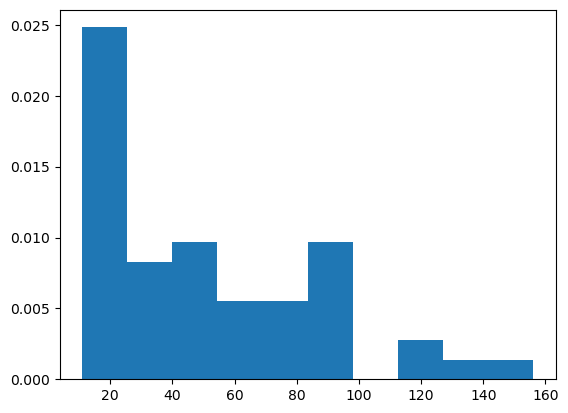

In [7]:
_ = plt.hist(cum_rs, density=True, label='expert')

In [8]:
batch_size = 1024
n_updates = 8000

critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))

    # sampled_exps = memory.sample(batch_size)
    # _s, _a, _r, _snext, _end = prepare_training_inputs(sampled_exps)
    # critic_loss = agent.update_critic(_s, _a, _snext, _r, _end)
    # actor_loss = agent.update_actor(_s, _a)
    # critic_losses.append(critic_loss.detach())
    # actor_losses.append(actor_loss.detach())
    for _s, _a, _snext, _r, _end in memory.sample(batch_size):
        critic_loss = agent.update_critic(_s, _a, _snext, _r, _end)
        actor_loss = agent.update_actor(_s, _a)
        critic_losses.append(critic_loss.detach())
        actor_losses.append(actor_loss.detach())
        break


fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


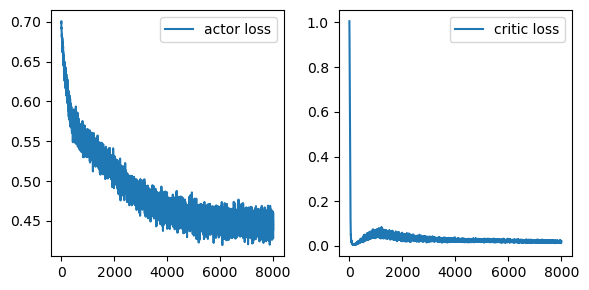

In [9]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
fig.tight_layout()

In [10]:
awac_cum_rs = []
for n_epi in range(50):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break

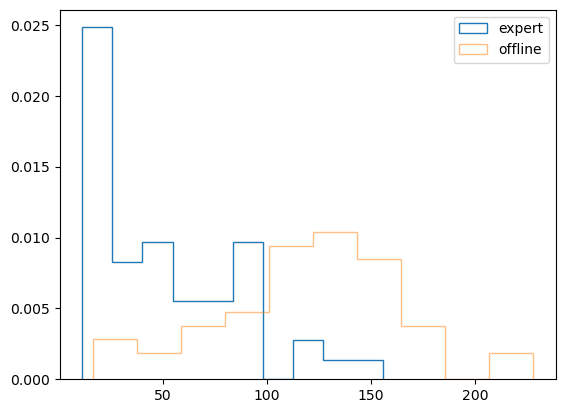

In [11]:
plt.hist(cum_rs, density=True, label='expert', histtype='step')
plt.hist(awac_cum_rs,
         alpha=0.5,
         density=True, label='offline', histtype='step')
plt.legend()

# Replayer

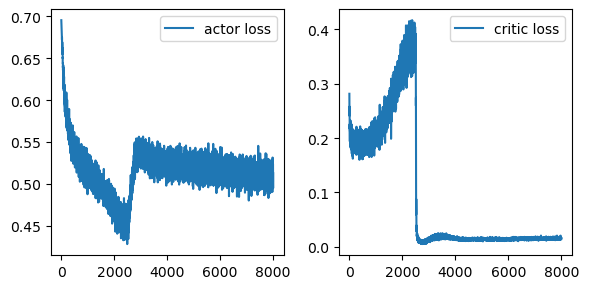

In [42]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
fig.tight_layout()

In [45]:
awac_cum_rs = []
for n_epi in range(50):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break

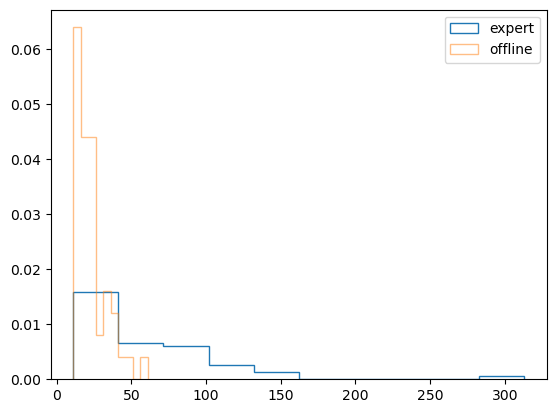

In [46]:
plt.hist(cum_rs, density=True, label='expert', histtype='step')
plt.hist(awac_cum_rs,
         alpha=0.5,
         density=True, label='offline', histtype='step')
plt.legend()